This notebook studies how well a sigmoid scaling law can fit the models' benchmark performances. One difference from existing works is that we add a treatment variable indicating whether the model is fine-tuned or not. The treatment effect is modelled as constant. Thus, the R^2 would depend on both the well-fitness of scaling law on pretrained models, and the variance of fine-tuning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'
SCALING_DIR = '/content/drive/MyDrive/LLM causality/Figures/Scaling Law/'

import os
if not os.path.exists(SCALING_DIR):
  os.mkdir(SCALING_DIR)

In [ ]:
import pandas as pd
df = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.optimize as opt
from sklearn.metrics import r2_score
import os
import warnings
import statsmodels.api as sm

plt.rcParams['font.family'] = 'serif'

SCALING_WITH_TREATMENT_DIR = '/content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/'
TREATMENT_VAR = 'Type'
MODEL_TYPES_TO_INCLUDE = ['🟢 pretrained', '🔶 fine-tuned on domain-specific datasets']
FINETUNED_TYPE = '🔶 fine-tuned on domain-specific datasets'
TITLE_FONTSIZE = 24
LABEL_FONTSIZE = 24
LEGEND_FONTSIZE = 20
TICK_FONTSIZE = 16

COLOR_PRETRAINED = 'blue'
MARKER_PRETRAINED = 'o'
COLOR_FINETUNED = 'red'
MARKER_FINETUNED = 's'
COLOR_FIT_T0 = 'darkblue'
COLOR_FIT_T1 = 'darkred'

def fit_scaling_law_with_treatment(df, benchmark, output_dir=SCALING_WITH_TREATMENT_DIR):
    """
    Fits a modified sigmoid scaling law (including a treatment effect for fine-tuning)
    to benchmark data based on pretraining compute, calculates the Average Treatment Effect (ATE)
    using backdoor adjustment, visualizes the fit and residual variance, and saves the plots.
    Distinguishes between Pretrained (T=0) and Fine-tuned (T=1) models in plots.

    Args:
        df (pd.DataFrame): DataFrame containing the model data.
                           Requires columns: '#Params (B)', 'Pretraining tokens (T)',
                           'Type', the specified benchmark column, and 'Official Providers'.
        benchmark (str): The name of the benchmark column to plot on the y-axis.
        output_dir (str): Directory to save the output plot PDF files.

    Returns:
        tuple: A tuple containing:
               - r_squared_all (float or None): R-squared for the overall fit.
               - ate_estimate (float or None): Estimated Average Treatment Effect.
               Returns (None, None) if fitting or ATE calculation fails or data is insufficient.
    """
    print(f"\n--- Processing Benchmark: {benchmark} ---")
    r_squared_all = None
    ate_estimate = None # Initialize ATE
    popt = None
    params_all_info = "Fit Failed"

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
        warnings.simplefilter("ignore", category=RuntimeWarning) # Ignore log/sqrt warnings here, handle explicitly

        # Ensure required columns exist
        required_cols = ['#Params (B)', 'Pretraining tokens (T)', 'Type', benchmark, 'Official Providers']
        if not all(col in df.columns for col in required_cols):
            print(f"Error: DataFrame missing one or more required columns: {required_cols}")
            return None, None

        # --- Initial Filtering (NaNs in key columns) ---
        df_filtered = df[df['#Params (B)'].notna() &
                         df['Pretraining tokens (T)'].notna() &
                         df[benchmark].notna()].copy()
        if df_filtered.empty:
            print("Error: No valid data after filtering NaNs in parameters, tokens, or benchmark score.")
            return None, None

        # Calculate pretraining compute
        df_filtered.loc[:, 'Pretraining compute'] = 6 * df_filtered['#Params (B)'] * df_filtered['Pretraining tokens (T)']

        # --- Filter Non-Positive Compute ---
        original_rows_compute = len(df_filtered)
        df_filtered = df_filtered[df_filtered['Pretraining compute'] > 0].copy()
        removed_rows_compute = original_rows_compute - len(df_filtered)
        if removed_rows_compute > 0:
            print(f"Info: Removed {removed_rows_compute} rows with non-positive 'Pretraining compute' values.")
        if df_filtered.empty:
            print("Error: No data remaining after filtering non-positive compute values.")
            return None, None # Updated return signature

        # Filter for specified model types and providers
        df_subset = df_filtered[df_filtered['Type'].isin(MODEL_TYPES_TO_INCLUDE) & df_filtered['Official Providers']].copy()
        if df_subset.empty:
            print(f"Error: No models found with types: {MODEL_TYPES_TO_INCLUDE} and Official Providers=True after initial filtering.")
            return None, None # Updated return signature

        # --- Create Treatment Variable ---
        # T = 1 if fine-tuned, 0 if pretrained
        df_subset.loc[:, 'Treatment'] = (df_subset['Type'] == FINETUNED_TYPE).astype(int)


    # --- ATE Calculation using Backdoor Adjustment ---
    print("\n--- Calculating Average Treatment Effect (ATE) ---")
    try:
        # Check if there are both treated and control units overall
        if df_subset['Treatment'].nunique() < 2:
            print("Warning: Not enough variation in Treatment variable to calculate ATE.")
            ate_estimate = None
        else:
            unique_compute_values = df_subset['Pretraining compute'].unique()
            print(f"Found {len(unique_compute_values)} unique 'Pretraining compute' values for ATE calculation.")
            if len(unique_compute_values) > 500: # Add a warning if compute seems too continuous
                 print("Warning: A large number of unique compute values found. The 'discrete confounder' assumption might be less appropriate.")

            ate_sum = 0.0
            total_weight = 0.0 # Keep track of the total weight used (sum of P(X=x) for valid x)

            for compute_val in unique_compute_values:
                df_compute_subset = df_subset[df_subset['Pretraining compute'] == compute_val]
                prob_x = len(df_compute_subset) / len(df_subset) # Calculate P(X=x)

                # Calculate E[Y | T=1, X=x]
                treated_group = df_compute_subset[df_compute_subset['Treatment'] == 1]
                mean_y_t1 = treated_group[benchmark].mean() if not treated_group.empty else np.nan

                # Calculate E[Y | T=0, X=x]
                control_group = df_compute_subset[df_compute_subset['Treatment'] == 0]
                mean_y_t0 = control_group[benchmark].mean() if not control_group.empty else np.nan

                # Only include this compute value if BOTH conditional means are calculable
                if not np.isnan(mean_y_t1) and not np.isnan(mean_y_t0):
                    diff_means = mean_y_t1 - mean_y_t0
                    ate_sum += diff_means * prob_x
                    total_weight += prob_x

            # Normalize ATE by the total weight of compute values included
            if total_weight > 0:
                ate_estimate = ate_sum / total_weight
                print(f"Estimated ATE (Backdoor Adjustment): {ate_estimate:.4f}")
                print(f"(Based on {total_weight*100:.1f}% of the data where both T=0 and T=1 were present for a given compute value)")
            else:
                print("Warning: Could not calculate ATE. No compute values had data for both treatment groups.")
                ate_estimate = None

    except Exception as e:
        print(f"Error during ATE calculation: {e}")
        ate_estimate = None

    # --- Modified Sigmoid Function with Treatment ---
    def sigmoid_with_treatment(x_T_tuple, L ,x0, k, b, c):
        """ Sigmoid function modified to include a linear treatment effect. """
        x, T = x_T_tuple
        exp_arg = np.clip(-k*(x-x0), -700, 700)
        with np.errstate(over='ignore', under='ignore', invalid='ignore'):
             denominator = 1 + np.exp(exp_arg)
             sigmoid_part = L / denominator + b
             y = sigmoid_part + c * T
             y = np.where(np.isfinite(y), y, np.nan)
        return y

    # --- Curve Fitting ---
    x_data_log = np.log(df_subset['Pretraining compute'].astype(float))
    y_data = df_subset[benchmark]
    T_data = df_subset['Treatment'] # Treatment variable

    valid_indices = np.isfinite(x_data_log) & np.isfinite(y_data) & np.isfinite(T_data)
    if not valid_indices.all():
        removed_count = len(x_data_log) - valid_indices.sum()
        print(f"Warning: Removing {removed_count} rows with non-finite log(compute), y, or T values before fitting.")
        x_data_log = x_data_log[valid_indices]
        y_data = y_data[valid_indices]
        T_data = T_data[valid_indices]
        df_subset = df_subset[valid_indices].copy() # IMPORTANT: Keep df_subset consistent

    if len(x_data_log) < 5: # Check after all filtering
        print("Error: Not enough data points (< 5) remaining after filtering for fitting.")
        if len(x_data_log) > 0:
             plt.figure(figsize=(12, 8)) # Adjusted size slightly
             df_plot_pt = df_subset[df_subset['Treatment']==0]
             df_plot_ft = df_subset[df_subset['Treatment']==1]
             if not df_plot_pt.empty:
                  x_plot_vals = np.log(df_plot_pt['Pretraining compute'].astype(float))
                  valid_plot = np.isfinite(x_plot_vals) & np.isfinite(df_plot_pt[benchmark])
                  plt.scatter(x_plot_vals[valid_plot], df_plot_pt.loc[valid_plot, benchmark],
                              c=COLOR_PRETRAINED, alpha=0.7, edgecolors='k', linewidth=0.5,
                              marker=MARKER_PRETRAINED, label='Pretrained (T=0)')
             if not df_plot_ft.empty:
                  x_plot_vals = np.log(df_plot_ft['Pretraining compute'].astype(float))
                  valid_plot = np.isfinite(x_plot_vals) & np.isfinite(df_plot_ft[benchmark])
                  plt.scatter(x_plot_vals[valid_plot], df_plot_ft.loc[valid_plot, benchmark],
                              c=COLOR_FINETUNED, alpha=0.7, edgecolors='k', linewidth=0.5,
                              marker=MARKER_FINETUNED, label='Fine-tuned (T=1)')

             plt.xlabel('log(Pretraining Compute Estimate)', fontsize=LABEL_FONTSIZE)
             plt.ylabel(f'{benchmark} Score', fontsize=LABEL_FONTSIZE)
             plt.title(f'Scaling Law: {benchmark} vs. log(Compute) - Insufficient Data for Fit', fontsize=TITLE_FONTSIZE, fontweight='bold')
             plt.grid(True, linestyle='--', alpha=0.6)
             if not df_plot_pt.empty or not df_plot_ft.empty:
                 plt.legend(fontsize=LEGEND_FONTSIZE)
             plt.tight_layout()
             try:
                os.makedirs(output_dir, exist_ok=True)
                safe_benchmark_name = "".join(c if c.isalnum() else "_" for c in benchmark)
                filename = os.path.join(output_dir, f'scaling_law_treatment_{safe_benchmark_name}_no_fit.pdf')
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Scatter plot saved (no fit possible): {filename}")
                plt.close()
             except Exception as e:
                print(f"Error saving scatter plot: {e}")
                plt.close()
        return None, ate_estimate

    x_T_combined = (x_data_log.to_numpy(), T_data.to_numpy())

    print(f"\n--- Fitting Sigmoid Model ---")
    print(f"Attempting fit for all {len(x_data_log)} valid points...")
    try:
        p0 = [np.nanmax(y_data), np.nanmedian(x_data_log), 1, np.nanmin(y_data), 0]
        if not np.all(np.isfinite(p0)):
             print("Warning: Non-finite values in initial guess p0. Adjusting...")
             p0 = [np.nanpercentile(y_data, 95) if np.isfinite(np.nanmax(y_data)) else 1.0,
                   np.nanmedian(x_data_log) if np.isfinite(np.nanmedian(x_data_log)) else 0.0,
                   1,
                   np.nanpercentile(y_data, 5) if np.isfinite(np.nanmin(y_data)) else 0.0,
                   0]
             print(f"Adjusted p0: {p0}")
        if not np.isfinite(p0[0]): p0[0] = np.nanmean(y_data) if np.isfinite(np.nanmean(y_data)) else 1.0
        if not np.isfinite(p0[3]): p0[3] = 0.0
        if not np.isfinite(p0[1]): p0[1] = np.nanmean(x_data_log) if np.isfinite(np.nanmean(x_data_log)) else 0.0

        bounds = ([0, -np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])
        popt, pcov = opt.curve_fit(sigmoid_with_treatment, x_T_combined, y_data,
                                   p0=p0, method='trf', maxfev=50000, bounds=bounds, ftol=1e-7, xtol=1e-7) # Adjusted maxfev/tolerance slightly
        y_pred = sigmoid_with_treatment(x_T_combined, *popt)

        if np.isnan(y_pred).any():
             print("Warning: Fit produced non-finite predicted values. Fit may be unstable.")
             r_squared_all = None
             popt = None
             params_all_info = "Fit Unstable (NaN/Inf)"
        else:
            r_squared_all = r2_score(y_data, y_pred)
            try:
                if np.isinf(np.diag(pcov)).any():
                    raise ValueError("Infinite variance found in pcov")
                perr = np.sqrt(np.diag(pcov))
                params_all_info = (
                    f"L={popt[0]:.2f}±{perr[0]:.2f}, x0={popt[1]:.2f}±{perr[1]:.2f}, "
                    f"k={popt[2]:.2f}±{perr[2]:.2f}, b={popt[3]:.2f}±{perr[3]:.2f}, "
                    f"c={popt[4]:.2f}±{perr[4]:.2f} (Treatment Effect Coeff)" # Label 'c' clearly
                )
            except (ValueError, RuntimeError) as diag_err:
                 print(f"Warning: Could not compute standard errors for the fit. Error: {diag_err}")
                 params_all_info = (
                    f"L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, "
                    f"b={popt[3]:.2f}, c={popt[4]:.2f} (SE Failed)"
                 )
            print(f"Fit Parameters: {params_all_info}")
            print(f"R-squared: {r_squared_all:.4f}")
            if ate_estimate is not None and popt is not None and len(popt) > 4:
                 print(f"Note: Backdoor ATE = {ate_estimate:.4f}, Model Treatment Coeff (c) = {popt[4]:.4f}")

    except (RuntimeError, ValueError) as e:
        print(f"Warning: Could not fit modified sigmoid curve. Error: {e}")
        popt = None # Ensure popt is None if fit fails
        r_squared_all = None
        params_all_info = f"Fit Failed ({type(e).__name__})"


    # --- Residual Variance Plot ---
    # Check if the main fit was successful before proceeding
    if popt is not None and len(x_data_log) > 10: # Need enough points for smoothing
        print("\n--- Generating Residual Variance Plot ---")
        y_pred_all_resid = sigmoid_with_treatment((x_data_log.to_numpy(), T_data.to_numpy()), *popt) # Use data that went into fit
        residuals = y_data - y_pred_all_resid # y_data corresponds to x_data_log
        squared_residuals = residuals**2

        try:
            df_resid_plot = df_subset.copy()
            df_resid_plot['log_compute'] = x_data_log # Add log compute used in fit
            df_resid_plot['sq_residuals'] = squared_residuals

            df_resid_pt = df_resid_plot[df_resid_plot['Treatment'] == 0]
            df_resid_ft = df_resid_plot[df_resid_plot['Treatment'] == 1]

            sort_indices = np.argsort(x_data_log)
            x_sorted = x_data_log.iloc[sort_indices]
            sq_resid_sorted = squared_residuals.iloc[sort_indices]

            lowess_smooth = sm.nonparametric.lowess(sq_resid_sorted, x_sorted, frac=0.5, is_sorted=True) # is_sorted=True for efficiency

            plt.figure(figsize=(10, 6))

            # Scatter plot of squared residuals, colored by treatment
            if not df_resid_pt.empty:
                 plt.scatter(df_resid_pt['log_compute'], df_resid_pt['sq_residuals'],
                             alpha=0.5, label='Squared Residuals (Pretrained)', s=20,
                             c=COLOR_PRETRAINED, marker=MARKER_PRETRAINED)
            if not df_resid_ft.empty:
                 plt.scatter(df_resid_ft['log_compute'], df_resid_ft['sq_residuals'],
                             alpha=0.5, label='Squared Residuals (Fine-tuned)', s=20,
                             c=COLOR_FINETUNED, marker=MARKER_FINETUNED)

            plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='black', linewidth=2, linestyle='--', label='LOWESS Smooth (Est. Variance)')

            plt.xlabel('log(Pretraining Compute Estimate)', fontsize=LABEL_FONTSIZE)
            plt.ylabel('Squared Residuals / Estimated Variance', fontsize=LABEL_FONTSIZE)
            plt.title(f'Residual Variance Check for {benchmark}', fontsize=TITLE_FONTSIZE, fontweight='bold')
            plt.legend(fontsize=LEGEND_FONTSIZE)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.xticks(fontsize=TICK_FONTSIZE)
            plt.yticks(fontsize=TICK_FONTSIZE)
            plt.tight_layout()

            try:
                os.makedirs(output_dir, exist_ok=True)
                safe_benchmark_name = "".join(c if c.isalnum() else "_" for c in benchmark)
                resid_filename = os.path.join(output_dir, f'residual_variance_{safe_benchmark_name}.pdf')
                plt.savefig(resid_filename, dpi=300, bbox_inches='tight')
                print(f"Residual variance plot saved to {resid_filename}")
                plt.close()
            except Exception as e:
                print(f"Error saving residual variance plot: {e}")
                plt.close()

        except ImportError:
            print("Warning: Cannot generate smoothed residual variance plot. Please install statsmodels: pip install statsmodels")
        except Exception as e:
            print(f"Error generating residual variance plot: {e}")
            plt.close() # Attempt to close plot if it was created but failed

    # --- Plotting Main Fit ---
    plt.figure(figsize=(10, 7))

    if not df_subset.empty:
        df_plot_pt = df_subset[df_subset['Treatment']==0]
        df_plot_ft = df_subset[df_subset['Treatment']==1]

        if not df_plot_pt.empty:
             x_vals_pt = np.log(df_plot_pt['Pretraining compute'].astype(float))
             valid_plot_pt = np.isfinite(x_vals_pt) & np.isfinite(df_plot_pt[benchmark])
             plt.scatter(x_vals_pt[valid_plot_pt], df_plot_pt.loc[valid_plot_pt, benchmark],
                         c=COLOR_PRETRAINED, alpha=0.7, edgecolors='k', linewidth=0.5,
                         marker=MARKER_PRETRAINED, label='Pretrained (T=0)')

        if not df_plot_ft.empty:
             x_vals_ft = np.log(df_plot_ft['Pretraining compute'].astype(float))
             valid_plot_ft = np.isfinite(x_vals_ft) & np.isfinite(df_plot_ft[benchmark])
             plt.scatter(x_vals_ft[valid_plot_ft], df_plot_ft.loc[valid_plot_ft, benchmark],
                         c=COLOR_FINETUNED, alpha=0.7, edgecolors='k', linewidth=0.5,
                         marker=MARKER_FINETUNED, label='Fine-tuned (T=1)')

    if popt is not None and not x_data_log.empty:
        x_plot_min = x_data_log.min()
        x_plot_max = x_data_log.max()
        if np.isfinite(x_plot_min) and np.isfinite(x_plot_max) and x_plot_min <= x_plot_max:
            if x_plot_min == x_plot_max:
                 x_plot = np.array([x_plot_min])
            else:
                 x_plot = np.linspace(x_plot_min, x_plot_max, 200)

            T_plot_0 = np.zeros_like(x_plot)
            T_plot_1 = np.ones_like(x_plot)

            y_plot_0 = sigmoid_with_treatment((x_plot, T_plot_0), *popt)
            if np.all(np.isfinite(y_plot_0)):
                 plt.plot(x_plot, y_plot_0, color=COLOR_FIT_T0, linestyle='-', linewidth=2,
                          label=f'Fit (T=0, Pretrained)') # R2 refers to overall fit now
            else:
                 print("Warning: Skipping plot for T=0 line due to non-finite values.")

            y_plot_1 = sigmoid_with_treatment((x_plot, T_plot_1), *popt)
            if np.all(np.isfinite(y_plot_1)):
                 plt.plot(x_plot, y_plot_1, color=COLOR_FIT_T1, linestyle='--', linewidth=2,
                          label=f'Fit (T=1, Fine-tuned, ' + r'$\tau$' + f'={popt[4]:.2f})') # Show treatment coeff
            else:
                 print("Warning: Skipping plot for T=1 line due to non-finite values.")
        else:
            print("Warning: Cannot determine plot range from x_data_log. Skipping curve plotting.")

    plt.xlabel('log(Pretraining Compute Estimate)', fontsize=LABEL_FONTSIZE, fontweight='bold')
    plt.ylabel(f'{benchmark} Score', fontsize=LABEL_FONTSIZE, fontweight='bold')
    plt.title(f'{benchmark} vs. log(Compute)', fontsize=TITLE_FONTSIZE, fontweight='bold')

    handles, labels = plt.gca().get_legend_handles_labels()

    plt.legend(handles=handles, labels=labels, fontsize=LEGEND_FONTSIZE, loc='best')
    plt.text(
        0.85, 0.95,
        r'$R^2$' + f' = {r_squared_all:.2f}',
        transform=plt.gca().transAxes,
        fontsize=16,
        verticalalignment='top',
        bbox=dict(
            boxstyle='round,pad=0.5',
            facecolor='white',
            alpha=0.8,
            edgecolor='#cccccc'
        )
    )

    plt.xticks(fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()


    try:
        os.makedirs(output_dir, exist_ok=True)
        safe_benchmark_name = "".join(c if c.isalnum() else "_" for c in benchmark)
        filename = os.path.join(output_dir, f'scaling_law_treatment_{safe_benchmark_name}.pdf')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")
        plt.close()
    except Exception as e:
        print(f"Error saving plot: {e}")
        plt.close()

    print(f"--- Finished Benchmark: {benchmark} ---")
    return r_squared_all, ate_estimate


In [ ]:
ATE_PLOT_DIR = SCALING_WITH_TREATMENT_DIR # Directory to save the ATE plot

cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']
ate_results = {}

for benchmark in cols_to_transform_new:
    print(f"\n--- Running Analysis for: {benchmark} ---")
    try:
        r_sq_all, ate = fit_scaling_law_with_treatment(df, benchmark)

        print(f"R-squared (All Points): {r_sq_all if r_sq_all is not None else 'N/A'}")
        print(f"ATE Estimate: {ate if ate is not None else 'N/A'}")

        if ate is not None:
            ate_results[benchmark] = ate
        else:
            print(f"Warning: ATE calculation failed or returned None for {benchmark}. Skipping for ATE plot.")

    except Exception as e:
        print(f"ERROR processing benchmark {benchmark}: {e}")


print("\n--- Analysis Loop Finished ---")
print("ATE Results Collected:", ate_results)


--- Running Analysis for: IFEval ---

--- Processing Benchmark: IFEval ---
Info: Removed 5 rows with non-positive 'Pretraining compute' values.

--- Calculating Average Treatment Effect (ATE) ---
Found 78 unique 'Pretraining compute' values for ATE calculation.
Estimated ATE (Backdoor Adjustment): 13.9408
(Based on 45.7% of the data where both T=0 and T=1 were present for a given compute value)

--- Fitting Sigmoid Model ---
Attempting fit for all 140 valid points...
Fit Parameters: L=17.25±3.53, x0=6.47±0.20, k=4.37±4.31, b=21.06±1.62, c=12.76±2.17 (Treatment Effect Coeff)
R-squared: 0.3615
Note: Backdoor ATE = 13.9408, Model Treatment Coeff (c) = 12.7579

--- Generating Residual Variance Plot ---
Residual variance plot saved to /content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/residual_variance_IFEval.pdf
Plot saved to /content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/scaling_law_treatment_IFEval.pdf
--- Finished Benchmark: IFEval ---
R-sq


--- Generating Enhanced ATE Comparison Plot ---
ATE comparison plot saved as PDF to /content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/ate_comparison_plot.pdf - Vector format for publications
ATE comparison plot saved as PNG to /content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/ate_comparison_plot.png - Raster format for presentations/web
ATE comparison plot saved as SVG to /content/drive/MyDrive/LLM causality/Figures/Scaling Law With Treatment/ate_comparison_plot.svg - Editable vector format


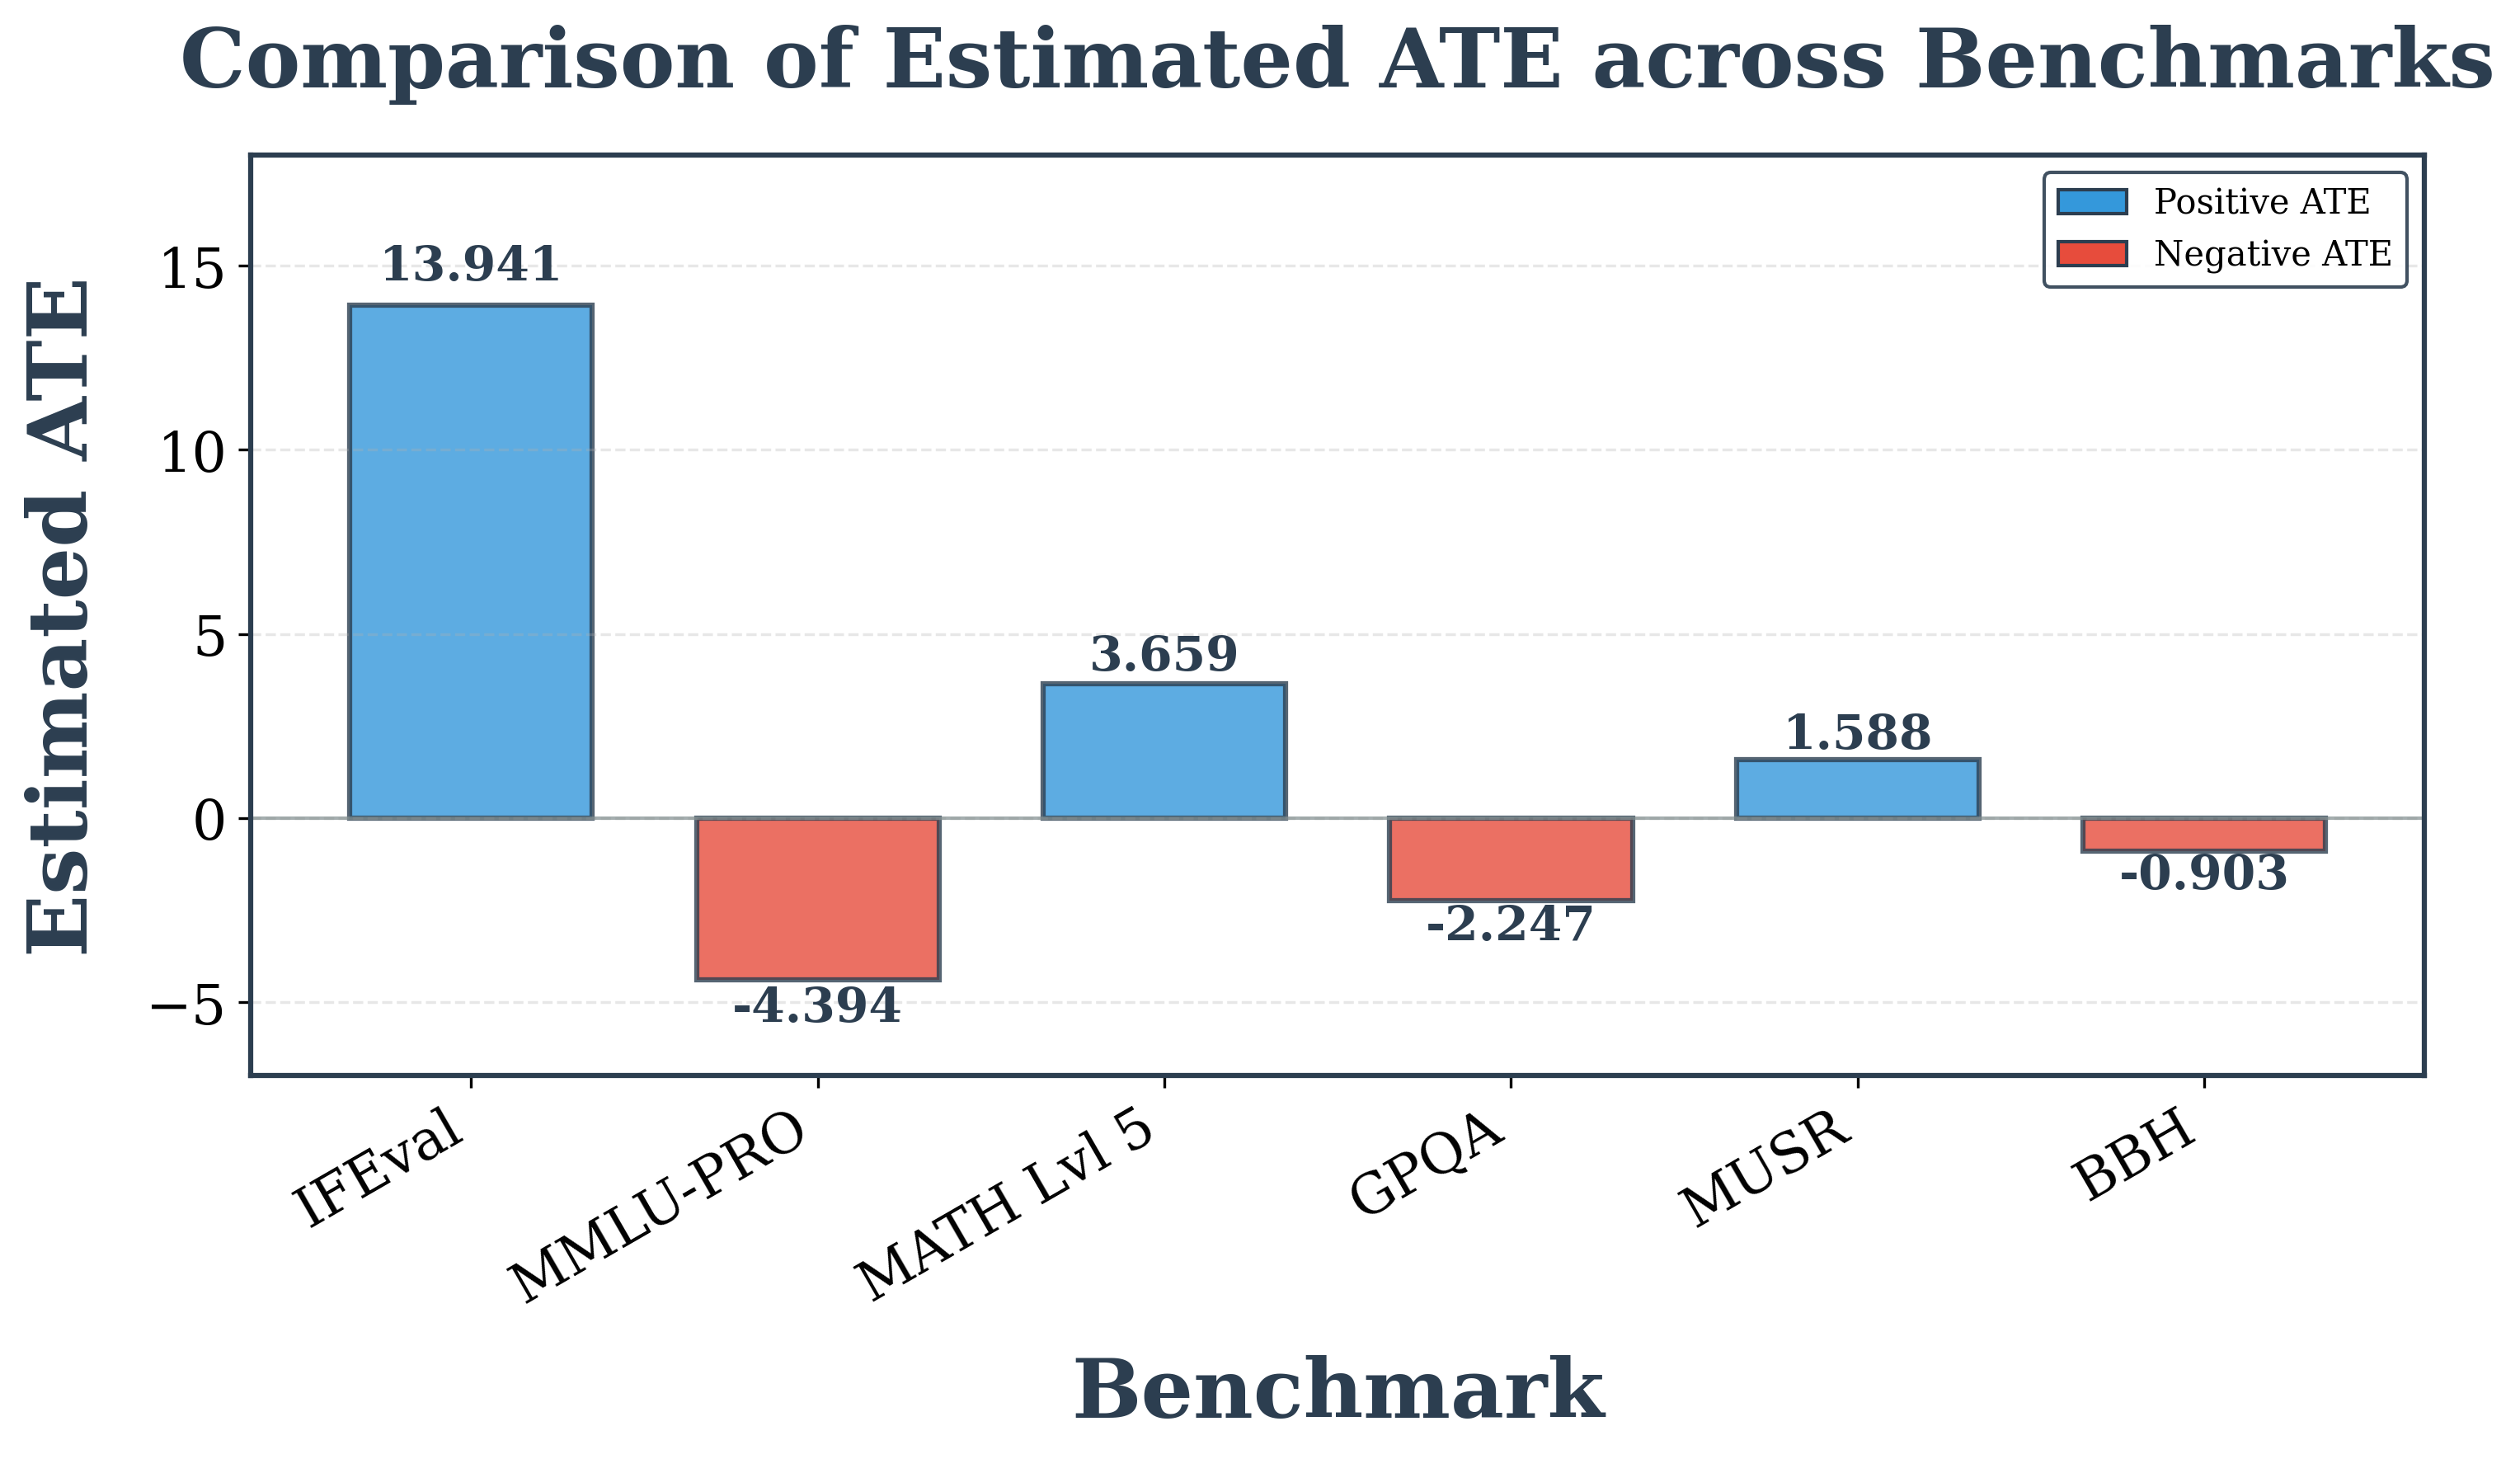

In [ ]:
# --- Generate Enhanced ATE Comparison Plot ---
if not ate_results:
    print("No valid ATE results were collected. Cannot generate ATE comparison plot.")
else:
    print("\n--- Generating Enhanced ATE Comparison Plot ---")

    # Sort results by ATE magnitude for better visualization
    sorted_items = sorted(ate_results.items(), key=lambda x: abs(x[1]), reverse=True)
    benchmarks, ates = zip(*sorted_items)

    colors = ['#3498db' if ate >= 0 else '#e74c3c' for ate in ates]

    plt.figure(figsize=(10, 6), dpi=300)

    bars = plt.bar(benchmarks, ates, color=colors, edgecolor='#2c3e50',
                  linewidth=1.5, alpha=0.8, width=0.7)

    plt.axhline(y=0, color='#7f8c8d', linestyle='-', linewidth=1, alpha=0.7)

    plt.xlabel('Benchmark', fontsize=LABEL_FONTSIZE, fontweight='bold',
              labelpad=12, color='#2c3e50')
    plt.ylabel('Estimated ATE',
              fontsize=LABEL_FONTSIZE, fontweight='bold',
              labelpad=12, color='#2c3e50')
    plt.ylim((-7, 18))
    plt.title('Comparison of Estimated ATE across Benchmarks',
             fontsize=TITLE_FONTSIZE, fontweight='bold',
             pad=20, color='#2c3e50')

    plt.xticks(rotation=30, ha='right', fontsize=TICK_FONTSIZE)
    plt.yticks(fontsize=TICK_FONTSIZE)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#2c3e50')

    plt.grid(True, linestyle='--', alpha=0.3, axis='y')

    for bar in bars:
        yval = bar.get_height()
        text_y_offset = max(0.01, abs(yval) * 0.03)
        position = 'bottom' if yval >= 0 else 'top'
        text_y = yval + text_y_offset if yval >= 0 else yval - text_y_offset

        text_color = '#2c3e50'
        text_fontweight = 'bold'
        text_fontsize = 14

        plt.text(bar.get_x() + bar.get_width()/2.0, text_y, f'{yval:.3f}',
                va=position, ha='center', fontsize=text_fontsize,
                fontweight=text_fontweight, color=text_color)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', edgecolor='#2c3e50', label='Positive ATE'),
        Patch(facecolor='#e74c3c', edgecolor='#2c3e50', label='Negative ATE')
    ]
    plt.legend(handles=legend_elements, loc='best', frameon=True,
              framealpha=0.9, edgecolor='#2c3e50')


    plt.tight_layout()

    try:
        os.makedirs(ATE_PLOT_DIR, exist_ok=True)

        formats = {
            'pdf': 'Vector format for publications',
            'png': 'Raster format for presentations/web',
            'svg': 'Editable vector format'
        }

        for fmt, desc in formats.items():
            filename = os.path.join(ATE_PLOT_DIR, f'ate_comparison_plot.{fmt}')
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"ATE comparison plot saved as {fmt.upper()} to {filename} - {desc}")

        try:
            if plt.isinteractive():
                plt.show()
        except:
            pass

        plt.close()
    except Exception as e:
        print(f"Error saving ATE comparison plot: {e}")
        plt.close()